C:\Users\ajeet\AppData\Local\Temp\ipykernel_33520\3329475152.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("saved_models/Faster_RCNN/

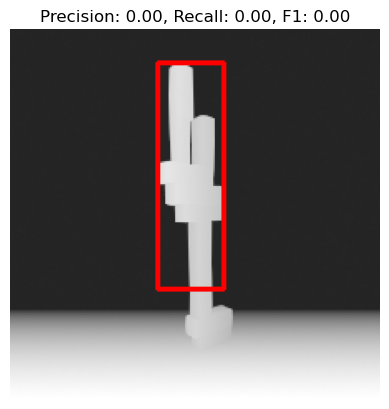

Precision: 0.0000, Recall: 0.0000, F1: 0.0000


In [76]:
import torchvision
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import torchvision.transforms as T
from sklearn.metrics import precision_score, recall_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load("saved_models/Faster_RCNN/TEST2_faster_rcnn_unstable.pth", map_location=device))
model.to(device)
model.eval()

def mask_to_bbox(mask_path):
    """Convert binary mask to bounding box coordinates"""
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    gt_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        gt_boxes.append([x, y, x+w, y+h])  # x1, y1, x2, y2 format
    
    return np.array(gt_boxes) if gt_boxes else np.zeros((0, 4))

def calculate_iou(box1, box2):
    """Calculate Intersection over Union (IoU) between two boxes"""
    # box format: [x1, y1, x2, y2]
    
    # Calculate intersection area
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # Calculate union area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area
    
    return intersection_area / union_area

def evaluate_predictions(pred_boxes, gt_boxes, iou_threshold=0.5):
    """Calculate precision, recall, and F1 score"""
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    matched_preds = set()
    
    for gt_idx, gt_box in enumerate(gt_boxes):
        best_iou = 0
        best_pred_idx = -1
        
        for pred_idx, pred_box in enumerate(pred_boxes):
            if pred_idx in matched_preds:
                continue
                
            iou = calculate_iou(pred_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_pred_idx = pred_idx
                
        if best_iou >= iou_threshold:
            true_positives += 1
            matched_preds.add(best_pred_idx)
        else:
            false_negatives += 1
    
    false_positives = len(pred_boxes) - len(matched_preds)
    
    # Calculate metrics
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

def predict_and_evaluate(model, image_path, mask_path, threshold=0.5, iou_threshold=0.5, vis=False):
    """Predict bounding boxes and evaluate against GT masks"""
    gt_boxes = mask_to_bbox(mask_path)

    img = Image.open(image_path).convert("RGB")
    img_tensor = T.ToTensor()(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        predictions = model(img_tensor)
    
    pred_boxes = predictions[0]["boxes"].cpu().numpy()
    pred_scores = predictions[0]["scores"].cpu().numpy()

    keep = pred_scores >= threshold
    pred_boxes = pred_boxes[keep]
    
    # NMS
    if len(pred_boxes) > 0:
        pred_boxes_tensor = torch.tensor(pred_boxes, dtype=torch.float32)
        scores_tensor = torch.tensor(pred_scores[keep], dtype=torch.float32)
        keep_nms = torchvision.ops.nms(pred_boxes_tensor, scores_tensor, iou_threshold)
        pred_boxes = pred_boxes[keep_nms.numpy()]

    precision, recall, f1 = evaluate_predictions(pred_boxes, gt_boxes, iou_threshold)
    
    if vis:
        img_cv = cv2.imread(image_path)
        img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
 
        for box in gt_boxes:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        for box in pred_boxes:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img_cv, (x1, y1), (x2, y2), (255, 0, 0), 2)
        
        plt.imshow(img_cv)
        plt.title(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")
        plt.axis("off")
        plt.show()
    
    return precision, recall, f1

image_path = "DEPTH-DS_SPLIT/10B-3D-Non/test/Unstable/render_68_persp_right.png"
mask_path = "mask_68.png"

precision, recall, f1 = predict_and_evaluate(
    model, 
    image_path, 
    mask_path, 
    threshold=0.2, 
    iou_threshold=0.3,
    vis=True
)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

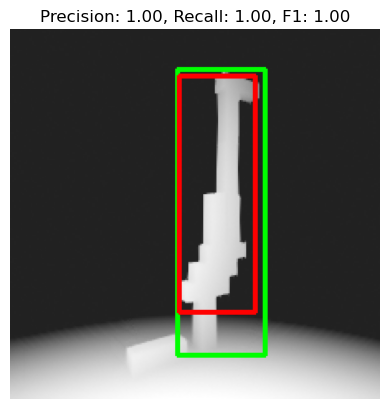

Image 1/50 - Precision: 1.0000, Recall: 1.0000, F1: 1.0000


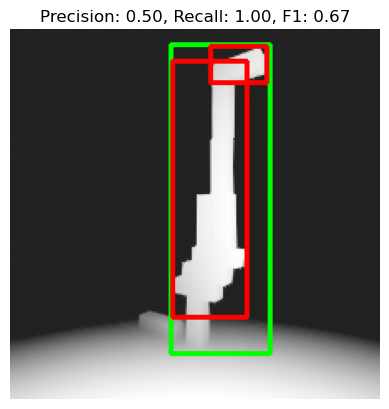

Image 2/50 - Precision: 0.5000, Recall: 1.0000, F1: 0.6667


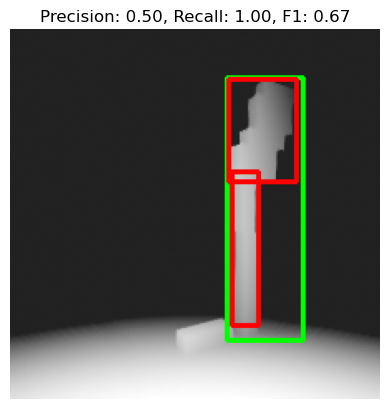

Image 3/50 - Precision: 0.5000, Recall: 1.0000, F1: 0.6667
Image 4/50 - Precision: 0.5000, Recall: 1.0000, F1: 0.6667
Image 5/50 - Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Image 6/50 - Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Image 7/50 - Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Image 8/50 - Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Image 9/50 - Precision: 0.5000, Recall: 1.0000, F1: 0.6667
Image 10/50 - Precision: 0.5000, Recall: 1.0000, F1: 0.6667
Image 11/50 - Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Image 12/50 - Precision: 0.5000, Recall: 1.0000, F1: 0.6667
Image 13/50 - Precision: 0.5000, Recall: 1.0000, F1: 0.6667
Image 14/50 - Precision: 0.5000, Recall: 1.0000, F1: 0.6667
Image 15/50 - Precision: 0.5000, Recall: 0.5000, F1: 0.5000
Image 16/50 - Precision: 0.5000, Recall: 0.5000, F1: 0.5000
Image 17/50 - Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Image 18/50 - Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Image 19/50 - Precision: 0.5000, Recall: 1.0000

In [78]:
import os
import glob
import numpy as np

def evaluate_dataset(model, image_dir, mask_dir, threshold=0.5, iou_threshold=0.5, display_count=3):
    """Evaluate model on entire dataset and display first few examples"""

    image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.png")))

    assert len(image_paths) == len(mask_paths), "Number of images and masks don't match"
 
    all_precision = []
    all_recall = []
    all_f1 = []
    
    for i, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
        precision, recall, f1 = predict_and_evaluate(
            model, 
            image_path, 
            mask_path, 
            threshold=threshold, 
            iou_threshold=iou_threshold,
            vis=(i < display_count)
        )
     
        all_precision.append(precision)
        all_recall.append(recall)
        all_f1.append(f1)
        
        print(f"Image {i+1}/{len(image_paths)} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    
    avg_precision = np.mean(all_precision)
    avg_recall = np.mean(all_recall)
    avg_f1 = np.mean(all_f1)
    
    print("\n=== Final Metrics ===")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")
    
    return avg_precision, avg_recall, avg_f1

image_dir = "Test_Dataset/ColourTest3/Depth_Blender/Before"
mask_dir = "Test_Dataset/ColourTest3/GTMasks"

avg_precision, avg_recall, avg_f1 = evaluate_dataset(
    model,
    image_dir,
    mask_dir,
    threshold=0.2,
    iou_threshold=0.3,
    display_count=3
)

Visualizing image 25: depth_222_persp_right.png0001.png
With mask: render_222_persp_right_before_mask.png


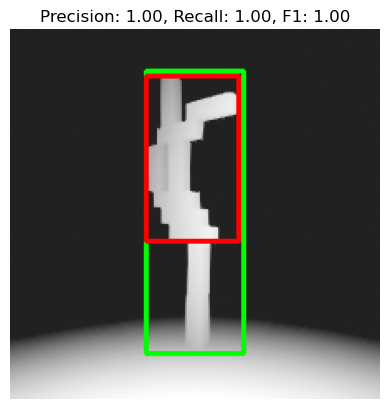

Precision: 1.0000, Recall: 1.0000, F1: 1.0000


In [100]:
def visualize_specific_image(model, image_dir, mask_dir, index, threshold=0.2, iou_threshold=0.3):

    image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.png")))

    if index >= len(image_paths):
        print(f"Error: Index {index} is out of range (max {len(image_paths)-1})")
        return
 
    image_path = image_paths[index]
    mask_path = mask_paths[index]
    
    print(f"Visualizing image {index}: {os.path.basename(image_path)}")
    print(f"With mask: {os.path.basename(mask_path)}")
    
    # Evaluate and visualize this specific image
    precision, recall, f1 = predict_and_evaluate(
        model, 
        image_path, 
        mask_path, 
        threshold=threshold, 
        iou_threshold=iou_threshold,
        vis=True
    )
    
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

visualize_specific_image(
    model,
    image_dir="Test_Dataset/ColourTest3/Depth_Blender/Before",
    mask_dir="Test_Dataset/ColourTest3/GTMasks",
    index=25  # Change this to any index you want to visualize
)

C:\Users\ajeet\AppData\Local\Temp\ipykernel_15368\712086483.py:153: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("saved_models/Faster_RCNN/

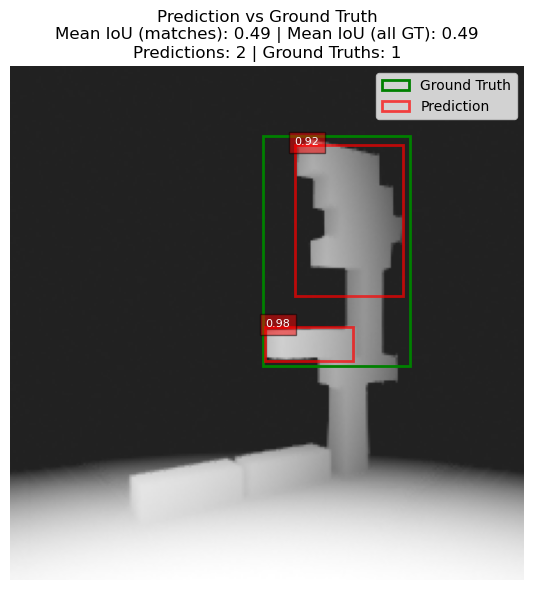


IoU Matrix (Rows: Predictions, Columns: Ground Truths):
[[0.09]
 [0.49]]

=== IoU Evaluation Results ===
Dataset Mean IoU (matched only): 0.5318
Dataset Mean IoU (counting misses): 0.5241
Match Rate: 96.30% (52/54)
Average Predictions per Image: 1.52


In [44]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def evaluate_dataset_iou(model, image_dir, mask_dir, confidence_threshold=0.5, visualize_index=None):

    import os
    import glob
    
    image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.png")))
    
    assert len(image_paths) == len(mask_paths), "Mismatch between images and masks"
    
    all_mean_ious = []
    all_mean_ious_per_gt = []
    total_matches = 0
    total_gt = 0
    total_pred = 0
    
    for idx, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
        gt_boxes = mask_to_bbox(mask_path)

        img = Image.open(image_path).convert("RGB")
        img_tensor = T.ToTensor()(img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            predictions = model(img_tensor)
        
        pred_boxes = predictions[0]["boxes"].cpu().numpy()
        pred_scores = predictions[0]["scores"].cpu().numpy()

        keep = pred_scores >= confidence_threshold
        pred_boxes = pred_boxes[keep]
        pred_scores = pred_scores[keep]
 
        mean_iou, mean_iou_per_gt, matched_ious = calculate_average_iou(pred_boxes, gt_boxes)
        
        all_mean_ious.append(mean_iou)
        all_mean_ious_per_gt.append(mean_iou_per_gt)
        total_matches += len(matched_ious)
        total_gt += len(gt_boxes)
        total_pred += len(pred_boxes)

        if visualize_index is not None and idx == visualize_index:
            visualize_prediction(
                image_path, 
                pred_boxes, 
                pred_scores, 
                gt_boxes, 
                mean_iou, 
                mean_iou_per_gt
            )

    dataset_mean_iou = np.mean(all_mean_ious)
    dataset_mean_iou_per_gt = np.mean(all_mean_ious_per_gt)
    match_rate = total_matches / total_gt if total_gt > 0 else 0
    
    print("\n=== IoU Evaluation Results ===")
    print(f"Dataset Mean IoU (matched only): {dataset_mean_iou:.4f}")
    print(f"Dataset Mean IoU (counting misses): {dataset_mean_iou_per_gt:.4f}")
    print(f"Match Rate: {match_rate:.2%} ({total_matches}/{total_gt})")
    print(f"Average Predictions per Image: {total_pred/len(image_paths):.2f}")
    
    return {
        'dataset_mean_iou': dataset_mean_iou,
        'dataset_mean_iou_per_gt': dataset_mean_iou_per_gt,
        'match_rate': match_rate,
        'per_image_ious': all_mean_ious,
        'per_image_ious_per_gt': all_mean_ious_per_gt
    }

def visualize_prediction(image_path, pred_boxes, pred_scores, gt_boxes, mean_iou, mean_iou_per_gt):

    fig, ax = plt.subplots(1, figsize=(8, 6))
    

    img = Image.open(image_path).convert("RGB")
    ax.imshow(img)
    
    for box in gt_boxes:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=2, edgecolor='g', facecolor='none', 
            label='Ground Truth'
        )
        ax.add_patch(rect)

    for box, score in zip(pred_boxes, pred_scores):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=2, edgecolor='r', facecolor='none',
            label='Prediction', alpha=0.7
        )
        ax.add_patch(rect)
        ax.text(
            x1, y1, f"{score:.2f}", 
            color='white', backgroundcolor='r', 
            fontsize=8, bbox=dict(facecolor='r', alpha=0.5)
        )

    iou_matrix = np.zeros((len(pred_boxes), len(gt_boxes)))
    for i, pred_box in enumerate(pred_boxes):
        for j, gt_box in enumerate(gt_boxes):
            iou_matrix[i,j] = calculate_iou(pred_box, gt_box)

    ax.set_title(
        f"Prediction vs Ground Truth\n"
        f"Mean IoU (matches): {mean_iou:.2f} | "
        f"Mean IoU (all GT): {mean_iou_per_gt:.2f}\n"
        f"Predictions: {len(pred_boxes)} | "
        f"Ground Truths: {len(gt_boxes)}"
    )
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    if len(pred_boxes) > 0 and len(gt_boxes) > 0:
        print("\nIoU Matrix (Rows: Predictions, Columns: Ground Truths):")
        print(np.round(iou_matrix, 2))

if __name__ == "__main__":

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    model.load_state_dict(torch.load("saved_models/Faster_RCNN/TEST2_faster_rcnn_unstable.pth", map_location=device))
    model.to(device)
    model.eval()

    image_dir = "Test_Dataset/ColourTest3/Depth_Blender/Before"
    mask_dir = "Test_Dataset/ColourTest3/GTMasks"

    results = evaluate_dataset_iou(
        model,
        image_dir,
        mask_dir,
        confidence_threshold=0.3,
        visualize_index=32  
    )